In [1]:
# import comet_ml in the top of your file
from comet_ml import Experiment

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_pretrained_bert import BertModel,BertTokenizer
from torch.nn.utils.rnn import pad_packed_sequence, pack_padded_sequence
import adabound
import random
import sklearn
from nltk import bleu_score
from sklearn.utils import shuffle
import torch.optim as optim
from matplotlib import pyplot
%matplotlib inline

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Add the following code anywhere in your machine learning file
experiment = Experiment(api_key="4as2djQjw8AFMMAemhjuGd7DJ",
                        project_name="bert4styletransfer", workspace="juravrik")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/juravrik/bert4styletransfer/d91b454844da4f58b12d07307f6c511f



In [2]:
PAD = 0
UNK = 1
CLS = 2
SEP = 3

In [3]:
bertpath = "../Bert-juman"
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
tokenizer = BertTokenizer.from_pretrained(bertpath, do_lower_case=False)
bert_trained = BertModel.from_pretrained(bertpath)
bert_trained = bert_trained.to(device)

In [5]:
def clean(sentence):
    sentence = tokenizer.tokenize(sentence)
    if len(sentence) > 300:
        sentence = sentence[:300] + ['[SEP]']
    sentence = tokenizer.convert_tokens_to_ids(sentence)
    return sentence

In [6]:
with open("./juman_reimu.csv") as f:
    text = f.read()

text = text.split("\n")
source = [clean(s) for s in text]

In [7]:
len(text)

1128

In [8]:
with open("./juman_marisa.csv") as f:
    text = f.read()
    
text = text.split("\n")
valid = [clean(s) for s in text[:10]]

In [12]:
tokenizer.convert_ids_to_tokens([0])

['[PAD]']

In [9]:
class DataLoader(object):
    def __init__(self, X, batch_size, bert_model):
        self.data = X
        self.batch_size = batch_size
        self.reset()
        self.bert_model = bert_model

    def reset(self):
        self.data = shuffle(self.data)
        self.start_index = 0

    def __iter__(self):
        return self

    def __next__(self):
        if self.start_index >= len(self.data):
            self.reset()
            raise StopIteration()

        X= self.data[self.start_index:self.start_index+self.batch_size]
        max_seq = max([len(x) for x in X])
        X = [x+[PAD for s in range(max_seq - len(x))] for x in X]
        X =torch.tensor(X, dtype=torch.long, device=device)

        with torch.no_grad():
            batch_embed, _ = self.bert_model(X, output_all_encoded_layers=False)

        batch_X = batch_embed[:, 0, :]
        batch_Y = X
         # ポインタを更新する
        self.start_index += self.batch_size
        return batch_X, batch_Y, max_seq

In [10]:
class DecoderCell(nn.Module):
    def __init__(self, n_embed_dim, n_hidden_dim, vovab_size):
        """
        :param hidden_size: int, 隠れ層のユニット数
        :param output_size: int, 出力言語の語彙数
        :param dropout: float, ドロップアウト率
        """
        super(DecoderCell, self).__init__()
        self.hidden_size = n_hidden_dim
        self.output_size = vovab_size

        self.embedding = nn.Embedding(vovab_size, n_embed_dim, padding_idx=0)
        self.lstm = nn.LSTM(n_embed_dim, n_hidden_dim, bidirectional=True)
        self.out = nn.Linear(n_hidden_dim*2, vovab_size)

    def forward(self, seqs, hidden):
        """
        :param seqs: tensor, 入力のバッチ, size=(1, batch_size)
        :param hidden: tensor, 隠れ状態の初期値, Noneの場合は0で初期化される
        :return output: tensor, Decoderの出力, size=(1, batch_size, output_size)
        :return hidden: tensor, Decoderの隠れ状態, size=(1, batch_size, hidden_size)
        """
        emb = self.embedding(seqs)
        output, hidden = self.lstm(emb, hidden)
        output = self.out(output)

        return F.softmax(output), hidden

In [15]:
class Decoder(nn.Module):
    def __init__(self, n_embed_dim, n_hidden_dim, vovab_size):
        super(Decoder, self).__init__()
        self.decodercell = DecoderCell(n_embed_dim, n_hidden_dim, vovab_size)
        
    def forward(self, hidden, batch_size, max_length, batch_Y=None, use_teacher_forcing=False):
        
        
        # decoderの入力と隠れ層の初期状態を定義
        decoder_input = torch.tensor([2] * batch_size, dtype=torch.long, device=device)
        decoder_input = decoder_input.unsqueeze(0)  # (1, batch_size)
                
        hidden = hidden.repeat(2, 1, 1)
        decoder_hidden = (hidden, hidden)  # Encoderの最終隠れ状態を取得

        # decoderの出力のホルダーを定義
        decoder_outputs = torch.zeros(max_length, batch_size, self.decodercell.output_size, device=device)

        # 各時刻ごとに処理
        for t in range(max_length):
            decoder_output, decoder_hidden = self.decodercell(decoder_input, decoder_hidden)
            decoder_outputs[t] = decoder_output
            # 次の時刻のdecoderの入力を決定
            if use_teacher_forcing and batch_Y is not None:  # ターゲット系列を用いる
                decoder_input = batch_Y[:, t].unsqueeze(0)
            else:  # 自身の出力を用いる
                decoder_input = decoder_output.max(-1)[1]
                
        return decoder_outputs

In [16]:
mce = nn.CrossEntropyLoss(size_average=False, ignore_index=0)
def criterion(logits, target):
    return mce(logits.view(-1, logits.size(-1)), target.view(-1))

In [17]:
def calc_bleu(refs, hyps):
    """
    BLEUスコアを計算する関数
    :param refs: list, 参照訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :param hyps: list, モデルの生成した訳。単語のリストのリスト (例： [['I', 'have', 'a', 'pen'], ...])
    :return: float, BLEUスコア(0~100)
    """
    refs = [[ref[:ref.index(SEP)]] for ref in refs]
    hyps = [hyp[:hyp.index(SEP)] if SEP in hyp else hyp for hyp in hyps]
    
    return 100 * bleu_score.corpus_bleu(refs, hyps)

In [18]:
model_args = {
    'n_hidden_dim': 768,
    'n_embed_dim': 300,
    'vovab_size': len(tokenizer.vocab)
}

In [19]:
params = {
    'batch_size': 32,
    'epoch': 10,
    'lr': 1e-3,
    'final_lr': 0.1,
    'model_args': model_args
}

In [20]:
experiment.log_parameters(params)

In [21]:
model = Decoder(**model_args).to(device)
#optimizer = adabound.AdaBound(model.parameters(), lr=params['lr'], final_lr=params['final_lr'])
optimizer = optim.Adam(model.parameters(), lr=params['lr'])

In [22]:
#log_train_loss = []
#log_train_bleu = []
#log_valid_bleu = []
best_valid_bleu = 0.

epoch0 start
train_sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


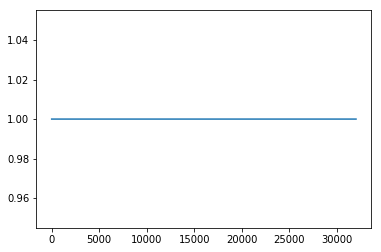

epooch0's train_loss:197.2464345296224
epooch0's train_bleu:0.0
sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
epooch0's valid_bleu:0.0
epoch1 start
train_sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


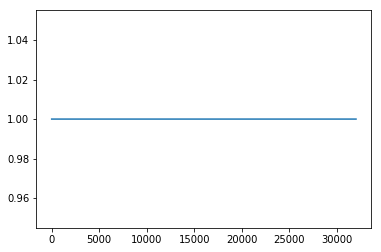

epooch1's train_loss:197.2464404816323
epooch1's train_bleu:0.0
sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
epooch1's valid_bleu:0.0
epoch2 start
train_sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


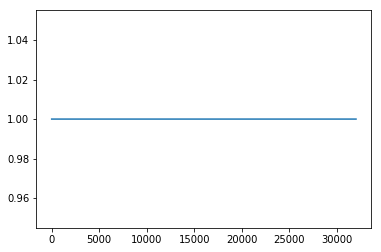

epooch2's train_loss:197.24642641324525
epooch2's train_bleu:0.0
sample:  [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
epooch2's valid_bleu:0.0
epoch3 start


In [ ]:
train_loader = DataLoader(source, params['batch_size'], bert_trained)
valid_loader = DataLoader(valid, params['batch_size'], bert_trained)

with experiment.train():
    for epoch in range(params['epoch']+1):
        print(f"epoch{epoch} start")
        train_loss = 0.
        train_bleu = 0.
        
        for X, y, l in train_loader:
            model.train()
            x = X.reshape(1, -1, 768).contiguous()
            #print(y.shape, X.shape)
            #print(l)
            use_teacher_forcing = random.random() < (1.0)**epoch
            if use_teacher_forcing:
                pred_y = model(x, x.shape[1], l, y, use_teacher_forcing=True)
            else:
                pred_y = model(x, x.shape[1], l)
            
            #print(y.contiguous().data.cpu()[0])
            
            loss = criterion(pred_y, y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()        
        
            train_loss += loss.item()
            train_bleu += calc_bleu(y.contiguous().data.cpu().tolist(),
                                    pred_y.max(dim=-1)[1].data.cpu().numpy().T.tolist())
        
        print("train_sample: "," ".join(tokenizer.convert_ids_to_tokens(pred_y.max(dim=-1)[1].data.cpu().numpy().T.tolist()[0])))
        pyplot.plot(pred_y[1, 0, :].data.cpu().numpy())
        pyplot.show()
    
        train_loss = train_loss / len(train_loader.data)
        train_bleu = train_bleu / len(train_loader.data)
        
        print(f"epooch{epoch}'s train_loss:{train_loss}")
        print(f"epooch{epoch}'s train_bleu:{train_bleu}")
        
        experiment.log_metric('train_loss', train_loss, step=epoch)
        experiment.log_metric('train_bleu', train_bleu, step=epoch)

        valid_bleu = 0.
        for X, y, l in valid_loader:
            model.eval()
            x = X.reshape(1, -1, 768).contiguous()
            pred_y = model(x, x.shape[1], l)
            
            print("sample: "," ".join(tokenizer.convert_ids_to_tokens(pred_y.max(dim=-1)[1].data.cpu().numpy().T.tolist()[0])))
            loss = criterion(pred_y, y.view(-1))       
            valid_bleu += calc_bleu(y.contiguous().data.cpu().tolist(),
                                    pred_y.max(dim=-1)[1].data.cpu().numpy().T.tolist())


        valid_bleu = valid_bleu / len(valid_loader.data)
        
        print(f"epooch{epoch}'s valid_bleu:{valid_bleu}")
        
        experiment.log_metric('valid_bleu', valid_bleu, step=epoch)
        
        #if valid_bleu > best_valid_bleu:
        #    ckpt = model.state_dict()
        #    torch.save(ckpt, "model.pth")
        #    best_valid_bleu = valid_bleu

In [26]:
# 学習済みモデルの読み込み
ckpt = torch.load("model.pth")
model.load_state_dict(ckpt)
model.eval()

RuntimeError: Error(s) in loading state_dict for Decoder:
	Missing key(s) in state_dict: "decodercell.lstm.weight_ih_l0", "decodercell.lstm.weight_hh_l0", "decodercell.lstm.bias_ih_l0", "decodercell.lstm.bias_hh_l0", "decodercell.lstm.weight_ih_l0_reverse", "decodercell.lstm.weight_hh_l0_reverse", "decodercell.lstm.bias_ih_l0_reverse", "decodercell.lstm.bias_hh_l0_reverse". 
	Unexpected key(s) in state_dict: "decodercell.gru.weight_ih_l0", "decodercell.gru.weight_hh_l0", "decodercell.gru.bias_ih_l0", "decodercell.gru.bias_hh_l0". 
	size mismatch for decodercell.embedding.weight: copying a param with shape torch.Size([32005, 768]) from checkpoint, the shape in current model is torch.Size([32005, 300]).
	size mismatch for decodercell.out.weight: copying a param with shape torch.Size([32005, 768]) from checkpoint, the shape in current model is torch.Size([32005, 1536]).

In [31]:
PAD

0

In [38]:
test_loader = DataLoader(source, params['batch_size'], bert_trained)
for X, y, l in test_loader:
    x = X.reshape(1, -1, 768).contiguous()
    pred_y = model(x, x.shape[1], l)
    print(pred_y.shape)
    for i, s in enumerate(pred_y.max(dim=-1)[1].data.cpu().numpy().T.tolist()):
        tre_s = y[i].tolist()
        print("true:", " ".join(tokenizer.convert_ids_to_tokens(tre_s[:tre_s.index(SEP)])))
        print("predict:", " ".join(tokenizer.convert_ids_to_tokens(s)))
        print()

torch.Size([50, 32, 32005])
true: [CLS] え ##ー ##っ と 、 あん ##た 誰 ##だ っ ##け ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] そんな もの 集めて いた っ ##け ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] い ##や ま ##あ 、 見た目 で 何 ##と ##なく ね 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

torch.Size([54, 32, 32005])
true: [CLS] な んだ って [UNK] 地獄 だって ？ このまま 深く 降りて いって 大 ##丈夫 ##な の か な 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] この お 屋敷 に 怨 ##霊 を 操 ##って いる 敵 が いる って 言う の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] （ 何 ##で 眠って いた のに 年数 が 判 ##る の か ##しら ？ ）
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

true: [CLS] 馬鹿 言って る んじゃ ない わ よ 。 今 ただ で さえ 急いで いる と 言う の に 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] そう だ っ ##け ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 紫 （ あん ##た ） … … ！ この タイミング で 出て くる と 言う 事 は 、 また 、 あん ##た が 絡んで いる の ね ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 当たり前 ##じゃ ない 。 誰 が 妖怪 の 言う 事 なんて 真に 受ける の よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

true: [CLS] ま ##あ 妖怪 だ し ね 。 [UNK] 退治 して おか ない と 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] ゾンビ で ##しょ ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] さっ ##き も 言った けど 天狗 に は 用 ##事 は ない わ 。 山 に 居る 神様 に 会い たい の 。
predict: [PAD] [PAD] [PAD] [

true: [CLS] さ ##ぁ 、 [UNK] に 戻る 覚悟 は いい ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] ん ？ 何 を 言って る の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 弱い 弱い 。 さ ##あ 、 また 封印 し ま ##しょ 。 今度 は 何 ##処 が 良い か な 。 白 ##蓮 の 代わり に 

true: [CLS] 中庭 ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 何 ##処 に 居る の か ##しら 、 あの 馬鹿 。 あの 地獄 [UNK] の 言う 事 が 本当 なら 、 今回 の 一連の 騒動 は 神 奈 ##子 の 仕業 に 決まって いる わ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

true: [CLS] 落ち ##葉 で 視界 が 良く ない わ ね 。 こんな 調子 で 山 に 立ち ##入 ##って 大 ##丈夫 か ##しら ？ あれ ？ 何 ##だか 美味 ##し そうな 匂い が … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] も しか して 、 宇宙 人 ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 紫 。 ほ ##ら 、 あ ##そこ の 扉 … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

true: [CLS] この 不思議な 嵐 も 、 打ち ##出 の 小 ##槌 の 影響 か な ？ なんて 禍 ##々しい 魔力 な の か ##しら 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 最近 、 宴会 が 多い じゃ ない 。 それ から 、 妖 ##霧 が 出て いて … … 。 って 、 私 の 行動 を 見て いる って 事 は や ##っぱり … … ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] へ ？ なん ##で ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 送り 返す んじゃ なくて

true: [CLS] ま ##ぁ … … そう ね 。 止める の は 一緒に 出て くる 怨 ##霊 だけ で 温泉 は 残して くれて も 良い んだ けど 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] こ 、 ここ まで 来た ##ら その 聖 ##者 と やら も 一 度 見て み ない と 戻 ##れ ない わ ね 。 気 に なって 眠 ##れ なく なり そうだ し 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] やっと 見つけた わ 。 あん ##た が 妖怪 の 親 ##玉 ね ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD

torch.Size([93, 32, 32005])
true: [CLS] しっ ##ぽ ##り は して ない けど 、 ちょっと 待って 。 人間 を 里 ごと 消して いる 妖怪 を [UNK] 訳 に は いか ない 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] さ ##ぁ 、 出て き なさい ！ 居る の は 分かって る わ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

torch.Size([40, 32, 32005])
true: [CLS] じゃ ##ぁ 、 略奪 開始 ##ー 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 蓋 を 開けて みれば ただ の 空 ##っぽ ##の 船 だ し 、 何 か 乗って いる か と 思い き ##や 、 いつの ##間 ##にか 魔界 だし 、 もう うん ##ざ ##り だ わ ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] す 、 凄 ##い 負 の オーラ ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] こんな 湖 に 暴れ ##る ような 妖怪 が いた っ #

torch.Size([89, 32, 32005])
true: [CLS] 一 人 まで なら 大量 殺人 犯 じゃ ない から 大 ##丈夫 よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] … … しかし コマ 犬 か ##ぁ 。 アン ##タ も 四季 異変 と は 関係 な さ そう ね ##ぇ 。 後 、 残った 季節 は 一 つ しか 無い んだ けど 、 そこ も 期待 でき ない 気 が する … … 。 勘 が 鈍 ##った の か な ##ぁ 。 ここ まで 全く 異変 の 手 ##掛 ##かり が ない なんて 。 それとも 、 今 まで 戦った 奴 ら の 何 ##処 か に 何 か 重大な 見 ##落とし が … … ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

torch.Size([48, 32, 32005])
true: [CLS] そう ？ 既に 何 か が 起こって いる 様に も 見える んだ けど … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 旧 都 ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] は ##い ？ 幻想 郷 に 攻めて きた の は 貴方 達 で ##しょ ？ 破壊 者 は 貴方 達 じゃ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

torch.Size([56, 32, 32005])
true: [CLS] [UNK] 、 その 友人 ？ の いる ところ まで 案内 して くれる か な 。 私 に は 目的 が 良く 判 ##ら なく なって 来 ##ちゃ った 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 鳥 の 目 は ご ##ま ##かせ ##て も 。 私 の 目 は ご ##ま ##かせ ない わ 。 あん ##たら が 動く たび に 、 時刻 が 止まる 。 夜 が 延びる 。 夜 を 止めて いる 犯人 は 、 あん ##たら だ ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] マ ##ミ ##ゾ ##ウ ？ 変 ##な 名前 。
predict: [

torch.Size([150, 32, 32005])
true: [CLS] おっ と 、 用 が 無い わけ ##じゃ ない ので 帰ら ない わ よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CL

torch.Size([43, 32, 32005])
true: [CLS] ま 、 実は 妖怪 の 味方 の 僧侶 が 寺 を 建てた の よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] や ##っぱり 下 ##克 ##上 を 企 ##んで いる の ね ？ 私 が そんな 話 に 乗る わけ が 無い で ##しょ ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] … … まさ ##か と 思った けど ここ って … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

true: [CLS] ちょっ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] [UNK] 化 した 道具 は 供養 する の が 習 ##わし だ けど … … お 祓 ##い 棒 の 件 も ある し ##ー 。 今回 は 原因 が 特殊 ##だ し ##ー 。 … … ま ##あ 大人 ##しく して いれば [UNK] あげ なく も ない わ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 軟禁 さ れて る の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [

torch.Size([65, 32, 32005])
true: [CLS] それ は その … … え ##ー ##っ と 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 雲 が 出て きた わ ね 。 見 ##失 ##った わ ##ー 。 あんな 小さな 蛇 。 ま ##あ 、 この 辺 異常に ＵＦＯ が 多い し 、 いざ と なれば 、 また こ ##じ ##開 ##けて みよう 。 ん ？ 何 か の 鳴き声 が する わ ね 。 鳥 ？ い ##や 、 この 鳴き声 は まさ ##か … … ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

torch.Size([58, 32, 32005])
true: [CLS] あれ ？ 会った っ ##け ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] な んだ って ボール の 事 を … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 知ら ん ！ 私 は ただ 宝 ##船 を 追って ここ まで 来た だけ だ し 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

true: [CLS] ふ ##ん 。 私 は 妖怪 に 味方 する 者 を 退治 して ま ##わる 巫女 よ ！ 妖怪 達 が 崇 ##めて いた 貴方 を 危険な 者 と 判断 した わ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] さすが の 嗅 ##覚 ね 。 もう 完全 憑 ##依 を 利用 して いる 奴 ら が 居る と は ね 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] あの 船 … … 音 も なく 飛び 去って いった 。 怪 ##しい わ ね 。 それ に 何 か 取り 憑 ##か れた ような 妖精 も いた ##し … … それ も 気 に なる わ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

torch.Size([66, 32, 32005])
true: [CLS] 年々 、 酷 ##く なって いる 気 が する わ ね 。 この 森 は 。 確か 、 ここ ら 辺 だった 様な 気 が した んだ けど … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] … … 今 の 奴 、 本当に 雀 だった の ？ 暗く ##て よく 見え なかった け 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS

true: [CLS] おっ ##と 、 思わ ##ぬ ところ で 情報 得た わ 。 何 が 目的 で 山 に 入って いる の か 忘れ かけて た ##し ね
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] … … ん ##ー 、 え ##ー ##っ と ？ それ って や ##っぱり 四季 異変 は 間接 的に あん ##たら の 仕業 な んじゃ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] え 、 あ 、 ああ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

true: [CLS] 冗談 じゃ ない 。 信仰 心 くらい 、 私 の 力 で 何とか 戻す わ よ ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 何 よ こい ##つ 。 変 ##な 猫 ね 。 でも 、 こい ##つ を 倒した から 間 ##欠 泉 は 元 に 戻る の か な ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] あん

torch.Size([37, 32, 32005])
true: [CLS] さ ##て 、 用 ##件 は な んだ っ ##け ？ 見事な 桜 に 見 ##と ##れて た わ よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] あん ##た 、 もし か ##して … … 本当に 下 ##克 ##上 を 企 ##んで … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 道 案内 あり ##が ##と 〜 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] め 、 女神 ？ あん ##た が ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

torch.Size([67, 32, 32005])
true: [CLS] は ##て 。 こんな ところ に 家 が あった っ ##け ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] わ 、 私 も 気 が 付いて いた わ よ 。 でも 、 さっ ##き の 奇妙な ボール は 一体 … … ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] ん ？ ちょっと 調査 に ね 。 本堂

torch.Size([68, 32, 32005])
true: [CLS] それ は ともかく 、 春 ##度 って 何 ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] いつ から 見て いた の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] い ##や 、 足り ない かも 知れ ない けど 。
predict: [PAD] [PAD] [PAD] [PAD

torch.Size([52, 32, 32005])
true: [CLS] … … 猫 ？ あの 猫 、 地 ##霊 殿 から ずっと 付いて くる んだ けど 何 か 嫌 ね ##ぇ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] え 、 あ 、 お ##は ##よ ##ー ござい ##ます 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 打ち ##出 の … … 小 ##槌 だって ！ ？ も しか して その 手 に ある の は … … 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] 

torch.Size([89, 32, 32005])
true: [CLS] 随 ##分 と 余裕 ね 。 闘い は これ から な のに 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] 私 は 好き ##じゃ ない わ 。 止めて くれる ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

torch.Size([43, 32, 32005])
true: [CLS] い ##や ##ー … … 何 ##と ##い ##う か 、 完全 憑 ##依 異変 の 解決 は 一 ##筋 ##縄 で は いか ない かも 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] もちろん 知ら ない ！
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] この 封印 の 下 に は 何 が 眠って いる の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] そこ

true: [CLS] 門 ##番 … … って 事 ？ 地獄 に 行か なき ##ゃ いけない んだ けど 、 どう すれば 良い の ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] そう な の 。 冥 ##界 （ ここ ） に 来た の は 見 ##当 ##違い って 事 ？
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

true: [CLS] さ ##ぁ ##て 、 道 案内 して もらい ます よ 。
predict: [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD

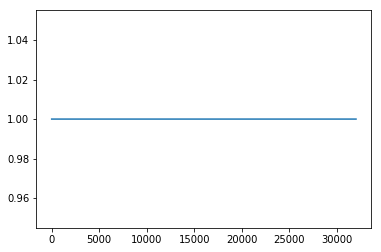

In [44]:

pyplot.plot(pred_y[1, 0, :].data.cpu().numpy())